<a href="https://colab.research.google.com/github/ulianagusar/air-alarm-prediction/blob/main/air_alarm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from keras.utils import to_categorical
import tensorflow as tf
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dropout, Dense, Conv1D, Flatten,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import os


# The data about losses is in a text document where each day is separated by a header and an empty line.

def read_the_required_lines(filename):
    # Removing headers
    filtered_lines = []
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            if ("напрям" not in line) and ("трат" not in line):
                filtered_lines.append(line)
    return filtered_lines

def add_date(lines, end_data):
    # Replace empty lines with the date when the data was published
    current_date = datetime.datetime.strptime(end_data, '%d.%m.%y')
    while "\n" in lines:
        index = lines.index("\n")
        lines[index] = current_date.strftime('%d.%m.%y')
        current_date -= datetime.timedelta(days=1)
    return lines

# Check if the string is a date
def is_valid_date(date_string, format='%d.%m.%y'):
    try:
        datetime.datetime.strptime(date_string, format)
        return True
    except ValueError:
        return False

# Check if the word is a number
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Some data has an extra dot after the number; this function removes them.
def removing_dots(lines):
    lines_without_dots = []
    for line in lines:
        if not is_valid_date(line):
            words = line.split()
            for word in words:
                if is_number(word):
                    if "." in word:
                        word = word.replace(".", "")
                        lines_without_dots.append(words[0] + " " + word)
                    else:
                        lines_without_dots.append(words[0] + " " + word)
        else:
            lines_without_dots.append(line)
    return lines_without_dots





# Correction of equipment names
def name_change(lines):
    for line_index in range(0, len(lines)):
        if "РСЗВ–" in lines[line_index]:
            lines[line_index] = lines[line_index].replace("РСЗВ–", "РСЗВ")
        if "кораблі/катери" in lines[line_index]:
            lines[line_index] = lines[line_index].replace("кораблі/катери", "кораблі")
    return lines

# Generating a dictionary with the category name of losses and values in the form of a list
def get_quantity(lines):
    columns = ["особового", "танків", "кораблі", "артилерійських", "РСЗВ", "бойових", "засоби",
               "літаків", "гелікоптерів", "автомобільної", "спеціальна", "крилаті", "БПЛА"]
    columns_dict = {name: [] for name in columns}
    for line in lines:
        for column in columns_dict:
            if column in line:
                columns_dict[column].append(float(line.split()[1]))
    return columns_dict



# Calculating the difference in values for each day
def diff(lst):
    for i in range(0, len(lst) - 1):
        lst[i] = lst[i] - lst[i + 1]
    return lst

# Applying the difference calculation to the columns in the dictionary
def diff_apply(columns_dict):
    for column in columns_dict:
        columns_dict[column] = diff(columns_dict[column])
    return columns_dict




# Replacing values in the list of lines from the file with cleaned data in the format
# date
# loss1 = 10
# loss2 = 9
# ...
def dict_to_lines(lines, columns_dict):
    lines_diff = []
    for line in lines:
        if is_valid_date(line):
            lines_diff.append(line)
        else:
            for column in columns_dict:
                if column in line:
                    lines_diff.append(line.split()[0] + " " + str(columns_dict[column][0]))
                    columns_dict[column].pop(0)
    return lines_diff


# Converting data into a DataFrame
def to_dataframe(lines):
    records = []
    record = {}
    for line in lines:
        if ('.23' in line) or ('.22' in line):
            if record:
                records.append(record)
                record = {}
            record['Date'] = line
        else:
            item, value = line.split()
            record[item] = float(value)
    if record:
        records.append(record)
    df = pd.DataFrame(records)
    return df


# Removing incorrectly read data
def error_removal(df):
    # Corrections for specific dates and columns
    df = df[:475]
    df.loc[df['Date'] == "09.05.23", 'особового'] = 540
    # ... (other corrections)
    df.drop(["кораблі"], axis=1, inplace=True)
    return df


# Applying functions to loss data file
def prepare_losses_data(filename, start_data):
    lines_read = read_the_required_lines(filename)
    lines_date = add_date(lines_read, start_data)
    lines = removing_dots(lines_date)
    lines = name_change(lines)
    columns_dict = get_quantity(lines)
    columns_dict = diff_apply(columns_dict)
    lines = dict_to_lines(lines, columns_dict)
    losses = to_dataframe(lines)
    return losses



# Load alarm data and combine into a single frame
def load_data(list_data):
    list_of_frame=[]
    for file_path in list_data:
        list_of_frame.append('pd.read_csv("'+file_path+'", delimiter=";")')

    alarms=concat_frames(list_of_frame)
    alarms['start'] = pd.to_datetime(alarms['start'])
    alarms['end'] = pd.to_datetime(alarms['end'])
    return alarms

# Concatenate frames from the input list
def concat_frames(list_of_frame,first=False):
     if first==False:
        alarm1=eval(list_of_frame.pop(0))
        alarm2=eval(list_of_frame.pop(0))
        alarms=pd.concat([alarm1, alarm2])
     else:
        alarm1=eval(list_of_frame.pop(-1))
        alarm2=eval(list_of_frame.pop(0))
        alarms=pd.concat([alarm1, alarm2])
     if list_of_frame !=[]:
        list_of_frame.append(alarms)
        concat_frames(list_of_frame,True)
     return alarms

# Calculate time to the next alarm
def time_to_next_alarm(alarms):
  # Group alarms by regions and sort by time
    alarms = alarms.sort_values(by=['region_city', 'start'])
  # Calculate the time interval to the next alarm for each region
    alarms['time_interval'] = alarms.groupby('region_city')['start'].shift(-1) - alarms['end']
  # Remove invalid values (negative time intervals and NaNs)
    alarms = alarms[~((alarms['time_interval'] < pd.Timedelta(0)) | alarms['time_interval'].isna())]
    alarms = alarms.sort_values(by='start')
    return alarms

# Calculate time to the previous alarm
def time_to_pre_alarm(alarms):
    alarms = alarms.sort_values(by=['region_city', 'start'])
    alarms['time_interval'] = alarms['start'] - alarms.groupby('region_city')['end'].shift(1)
    alarms = alarms[~((alarms['time_interval'] < pd.Timedelta(0)) | alarms['time_interval'].isna())]
    alarms = alarms.sort_values(by='start')
    return alarms


def get_fiches_alarms(alarms):

    alarms['start_date'] = pd.to_datetime(alarms['start']).dt.date
    alarms['start_time'] = pd.to_datetime(alarms['start']).dt.time

    alarms['start_day'] = pd.to_datetime(alarms['start_date']).dt.day
    alarms['start_hour'] = pd.to_datetime(alarms['start_time'], format='%H:%M:%S').dt.hour
    alarms['start_minutes'] = pd.to_datetime(alarms['start_time'], format='%H:%M:%S').dt.minute
    alarms['start_month'] = pd.to_datetime(alarms['start_date']).dt.month


    alarms['end_date'] = pd.to_datetime(alarms['end']).dt.date
    alarms['end_time'] = pd.to_datetime(alarms['end']).dt.time


    alarms['end_day'] = pd.to_datetime(alarms['end_date']).dt.day
    alarms['end_hour'] = pd.to_datetime(alarms['end_time'], format='%H:%M:%S').dt.hour
    alarms['end_minutes'] = pd.to_datetime(alarms['end_time'], format='%H:%M:%S').dt.minute
    alarms['end_month'] = pd.to_datetime(alarms['end_date']).dt.month
    return alarms


def merge_data(alarms,losses):
    losses['Date'] = pd.to_datetime(losses['Date'], format='%d.%m.%y')
    alarms['start_date'] = pd.to_datetime(alarms['start_date'], format='%Y-%m-%d')
    result = pd.merge(losses, alarms, left_on='Date', right_on='start_date', how='inner')
    return result


def get_fiches_result(result):
    result['duration'] = result['end'] - result['start']
    result['duration_minutes'] = result['duration'].dt.total_seconds() / 60
    result['time_interval']=result['time_interval'].dt.total_seconds() / 3600
    result['region_city_encoded'] = pd.factorize(result['region_city'])[0]
    result.insert(0,"region_city_encoded", result.pop("region_city_encoded"))
    result['Date'] = pd.to_datetime(result['Date'])
    result['DayOfWeek'] = result['Date'].dt.day_name()
    result['DayOfWeek'] = pd.factorize(result['DayOfWeek'])[0]
    result.drop(["start_time","start_date","id","duration","region_city","end","start","end_time","end_date"], axis=1,inplace=True)
    return result

# Load data about holidays
def get_holiday_uk(result):
      holiday_uk=pd.concat([pd.read_csv("/content/publicholiday.UA.2022.csv"), pd.read_csv("/content/publicholiday.UA.2023.csv")])

      holiday_uk = holiday_uk.drop(["LocalName", "Name", "CountryCode", "Fixed", "Global", "LaunchYear", "Type", "Counties"], axis=1)
      holiday_uk["Date"] = pd.to_datetime(holiday_uk["Date"])
      holiday_uk["holiday_ua"] = 1
      result = pd.merge(result, holiday_uk, left_on='Date', right_on='Date', how='left')

      result['holiday_ua'] = result['holiday_ua'].fillna(0).astype(int)
      return result

def get_holiday_ru(result):
      holiday_ru=pd.concat([pd.read_csv("/content/publicholiday.RU.2022.csv"), pd.read_csv("/content/publicholiday.RU.2023.csv")])

      holiday_ru = holiday_ru.drop(["LocalName", "Name", "CountryCode", "Fixed", "Global", "LaunchYear", "Type", "Counties"], axis=1)
      holiday_ru["Date"] = pd.to_datetime(holiday_ru["Date"])
      holiday_ru["holiday_ru"] = 1

      result = pd.merge(result, holiday_ru, left_on='Date', right_on='Date', how='left')
      result['holiday_ru'] = result['holiday_ru'].fillna(0).astype(int)
      return result

# Add data about fuel consumption and price changes

def get_fluel(result):
      fluel=pd.read_excel("/content/Fluel.xlsx")
      fluel=fluel[3:-1]
      fluel.dropna()
      fluel["зміна_бензин"]=fluel["бензин_ціна_з"]-fluel["бензин_ціна"]
      fluel["зміна_дизель"]=fluel["дизель_ціна.1"]-fluel["дизель_ціна"]
      fluel.drop([ 'Unnamed: 3', 'бензин_ціна', 'Unnamed: 5', 'бензин_ціна_з',  'дизель_ціна', 'дизель_ціна.1'], axis=1,inplace=True)
      fluel['start'] = pd.to_datetime(fluel['start'])
      fluel['end'] = pd.to_datetime(fluel['end'])

      result['бензин1'] = np.nan
      result['бензин2'] = np.nan
      result['дизель1'] = np.nan
      result['дизель2'] = np.nan


# Adding fuel data by dates
      for index, row in fluel.iterrows():
          start_date = row["start"]
          end_date = row["end"]
          result['бензин1'] = np.where(
              (result['Date'] >= start_date) & (result['Date'] <= end_date),
              row["бензин_про"],
              result['бензин1']
          )

          result['бензин2'] = np.where(
              (result['Date'] >= start_date) & (result['Date'] <= end_date),
              row["зміна_бензин"],
              result['бензин2']
          )

          result['дизель1'] = np.where(
              (result['Date'] >= start_date) & (result['Date'] <= end_date),
              row["дизель_по"],
              result['дизель1']
          )

          result['дизель2'] = np.where(
              (result['Date'] >= start_date) & (result['Date'] <= end_date),
              row["зміна_дизель"],
              result['дизель2']
          )
      return result


# Plot average alarm duration with and without regions that occur up to region_num times
def plot_region_del(result,region_num):
    grouped_data_data = result.groupby('Date')['time_interval'].agg(['mean']).reset_index()
    grouped_counts = result['region_city_encoded'].value_counts()
    values_to_remove = grouped_counts[grouped_counts <= region_num].index
    filtered_result = result[~result['region_city_encoded'].isin(values_to_remove)]
    grouped_data_clean = filtered_result.groupby('Date')['time_interval'].agg(['mean']).reset_index()

    plt.plot(grouped_data_data['mean'])
    plt.plot(grouped_data_clean['mean'])

def get_distribution(result):
    bin_edges=list(range(0,1000,20))
    plt.figure(figsize=(30, 6))
    plt.hist(result['time_interval'], bins=bin_edges, edgecolor='black', alpha=0.7)
    plt.xlabel('Time to Pre-Alarm')
    plt.ylabel('Number of Values')
    plt.title('Distribution of Time to Pre-Alarm')
    plt.xticks(bin_edges)
    plt.tight_layout()
    plt.show()

# Smooth and filter data after time_board and before region_board
def smoothed_result(result, time_board, region_board):


    filtered_result = result.loc[result['time_interval'] <= time_board]
    grouped_counts = filtered_result['region_city_encoded'].value_counts()
    values_to_remove = grouped_counts[grouped_counts <= region_board].index
    filtered_result = filtered_result[~filtered_result['region_city_encoded'].isin(values_to_remove)]


    smoothed = filtered_result.rolling(window=5).mean()
    smoothed = filtered_result.ewm(span=5, adjust=False).mean()
    smoothed["all_region"] = filtered_result["all_region"].values
    smoothed["region_city_encoded"] = filtered_result["region_city_encoded"].values
    smoothed["region_id"] = filtered_result["region_id"].values

    return smoothed

#splitting data into windows
def data_split(smoothed,target,window_size):
      X = []
      y = []


      for i in range(len(smoothed) - (window_size)):
          X.append(smoothed.iloc[i:i+window_size].values)
          y.append(smoothed.iloc[i+window_size][target])

      X = np.array(X)
      y = np.array(y)

      return X, y



def plot_predictions1(model, X, y, start=0, end=1000):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, MeanSquaredError(y, predictions)



filename = "/content/втрати_противника"
losses=prepare_losses_data(filename,'19.08.23')
losses=error_removal(losses)
alarms=load_data(["/content/alarms.csv","/content/alarms-from-26-06-2023.csv"])
alarms_next=time_to_next_alarm(alarms)
alarms_pre=time_to_pre_alarm(alarms)

alarms_next=get_fiches_alarms(alarms_next)
alarms_pre=get_fiches_alarms(alarms_pre)


result_next=merge_data(alarms_next,losses)
result_pre=merge_data(alarms_pre,losses)


result_next=get_fiches_result(result_next)
result_pre=get_fiches_result(result_pre)

result_next=get_fluel(result_next)
result_pre=get_fluel(result_pre)

result_next=result_next.dropna()
result_pre=result_pre.dropna()

<ipython-input-1-4c2bc6ccaed1>:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["кораблі"], axis=1, inplace=True)


In [ ]:

result_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21471 entries, 378 to 22964
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   region_city_encoded  21471 non-null  int64         
 1   Date                 21471 non-null  datetime64[ns]
 2   особового            21471 non-null  float64       
 3   танків               21471 non-null  float64       
 4   бойових              21471 non-null  float64       
 5   артилерійських       21471 non-null  float64       
 6   РСЗВ                 21471 non-null  float64       
 7   засоби               21471 non-null  float64       
 8   літаків              21471 non-null  float64       
 9   гелікоптерів         21471 non-null  float64       
 10  БПЛА                 21471 non-null  float64       
 11  крилаті              21471 non-null  float64       
 12  автомобільної        21471 non-null  float64       
 13  спеціальна           21471 no

In [ ]:
result_next.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21417 entries, 350 to 22882
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   region_city_encoded  21417 non-null  int64         
 1   Date                 21417 non-null  datetime64[ns]
 2   особового            21417 non-null  float64       
 3   танків               21417 non-null  float64       
 4   бойових              21417 non-null  float64       
 5   артилерійських       21417 non-null  float64       
 6   РСЗВ                 21417 non-null  float64       
 7   засоби               21417 non-null  float64       
 8   літаків              21417 non-null  float64       
 9   гелікоптерів         21417 non-null  float64       
 10  БПЛА                 21417 non-null  float64       
 11  крилаті              21417 non-null  float64       
 12  автомобільної        21417 non-null  float64       
 13  спеціальна           21417 no

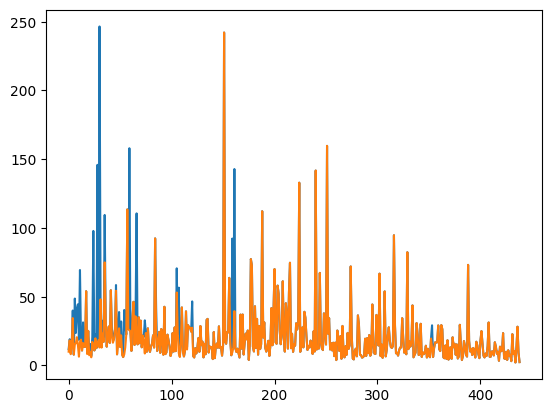

In [ ]:
plot_region_del(result_next,10)


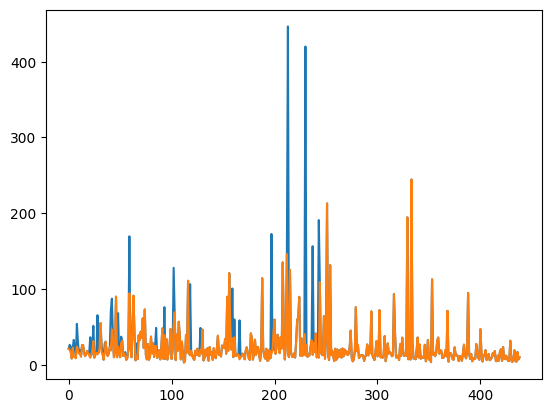

In [ ]:
plot_region_del(result_pre,4)

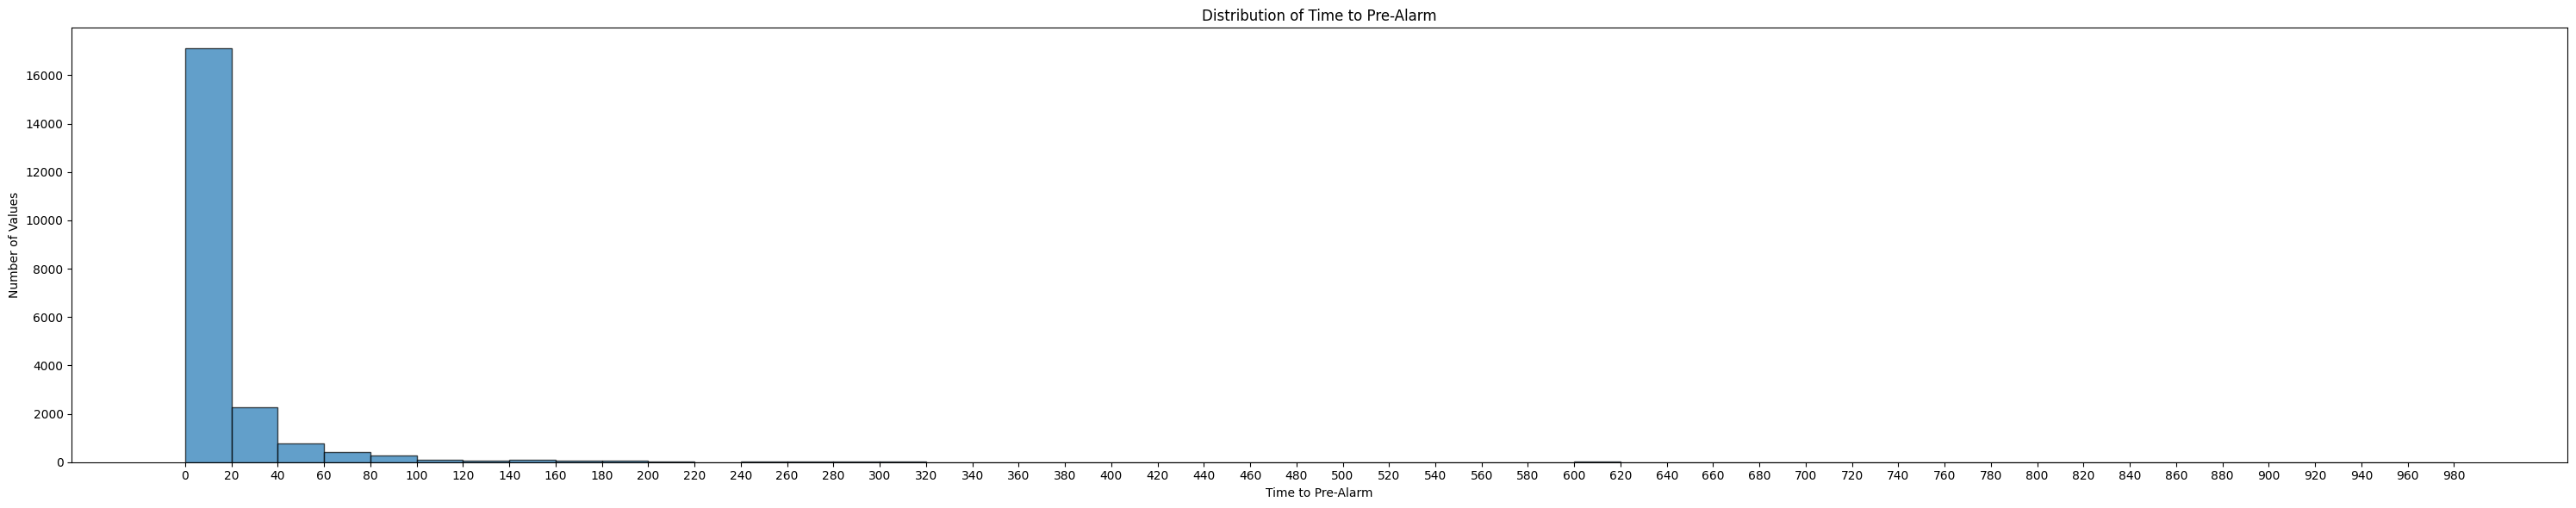

In [ ]:
get_distribution(result_pre)

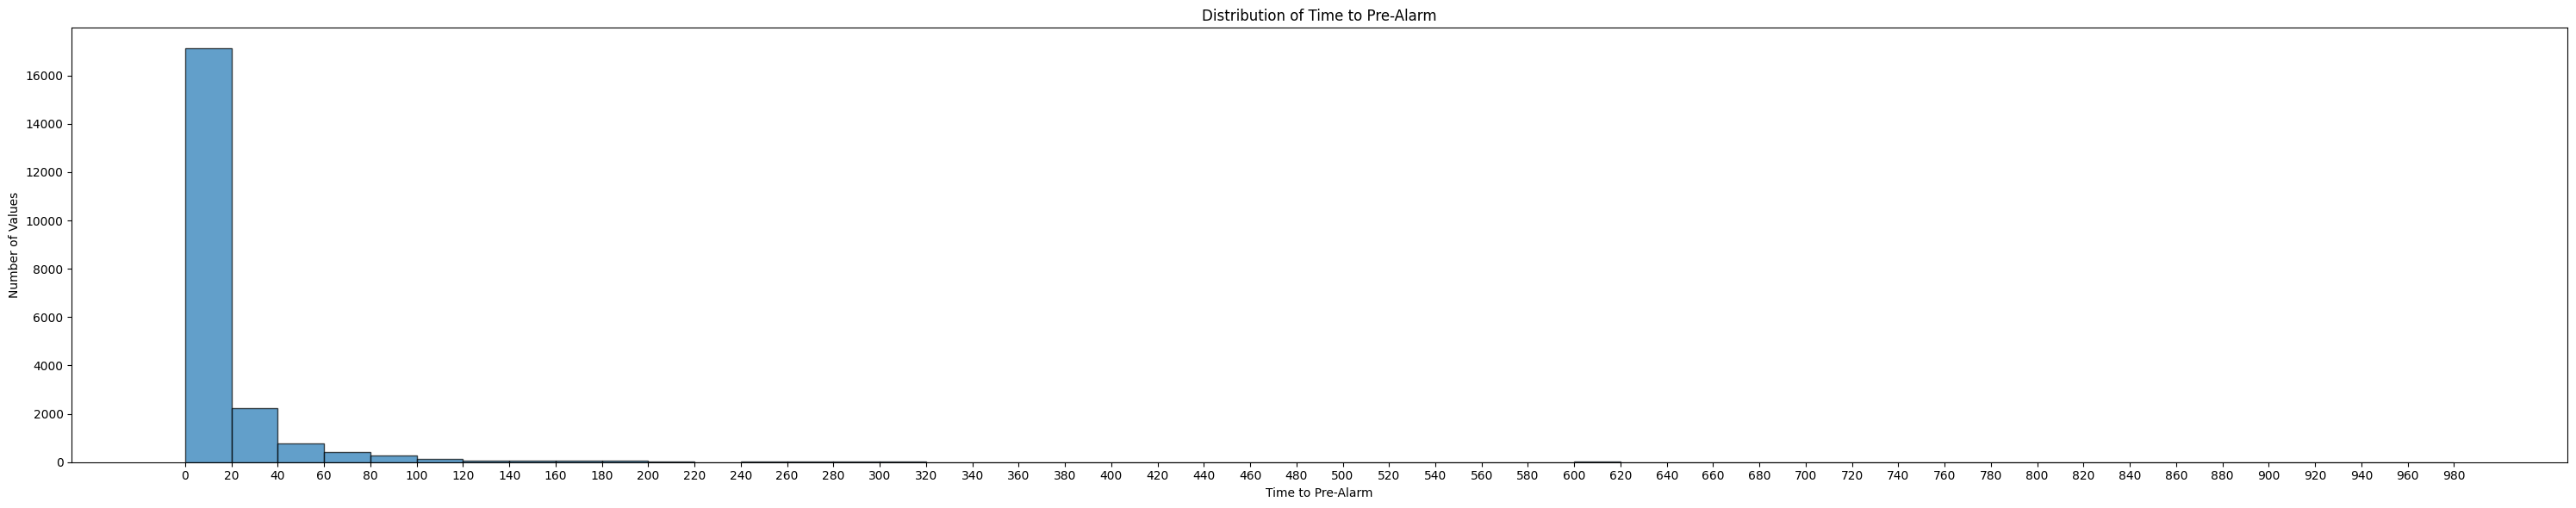

In [ ]:
get_distribution(result_next)

In [ ]:
result_pre.drop(["Date"],axis=1,inplace=True)
result_next.drop(["Date"],axis=1,inplace=True)

In [ ]:
result_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21471 entries, 378 to 22964
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   region_city_encoded  21471 non-null  int64  
 1   особового            21471 non-null  float64
 2   танків               21471 non-null  float64
 3   бойових              21471 non-null  float64
 4   артилерійських       21471 non-null  float64
 5   РСЗВ                 21471 non-null  float64
 6   засоби               21471 non-null  float64
 7   літаків              21471 non-null  float64
 8   гелікоптерів         21471 non-null  float64
 9   БПЛА                 21471 non-null  float64
 10  крилаті              21471 non-null  float64
 11  автомобільної        21471 non-null  float64
 12  спеціальна           21471 non-null  float64
 13  region_id            21471 non-null  int64  
 14  all_region           21471 non-null  int64  
 15  time_interval        21471 non-nul

In [ ]:

smoothed_pre=smoothed_result(result_pre,650,10)
smoothed_next=smoothed_result(result_next,900,5)

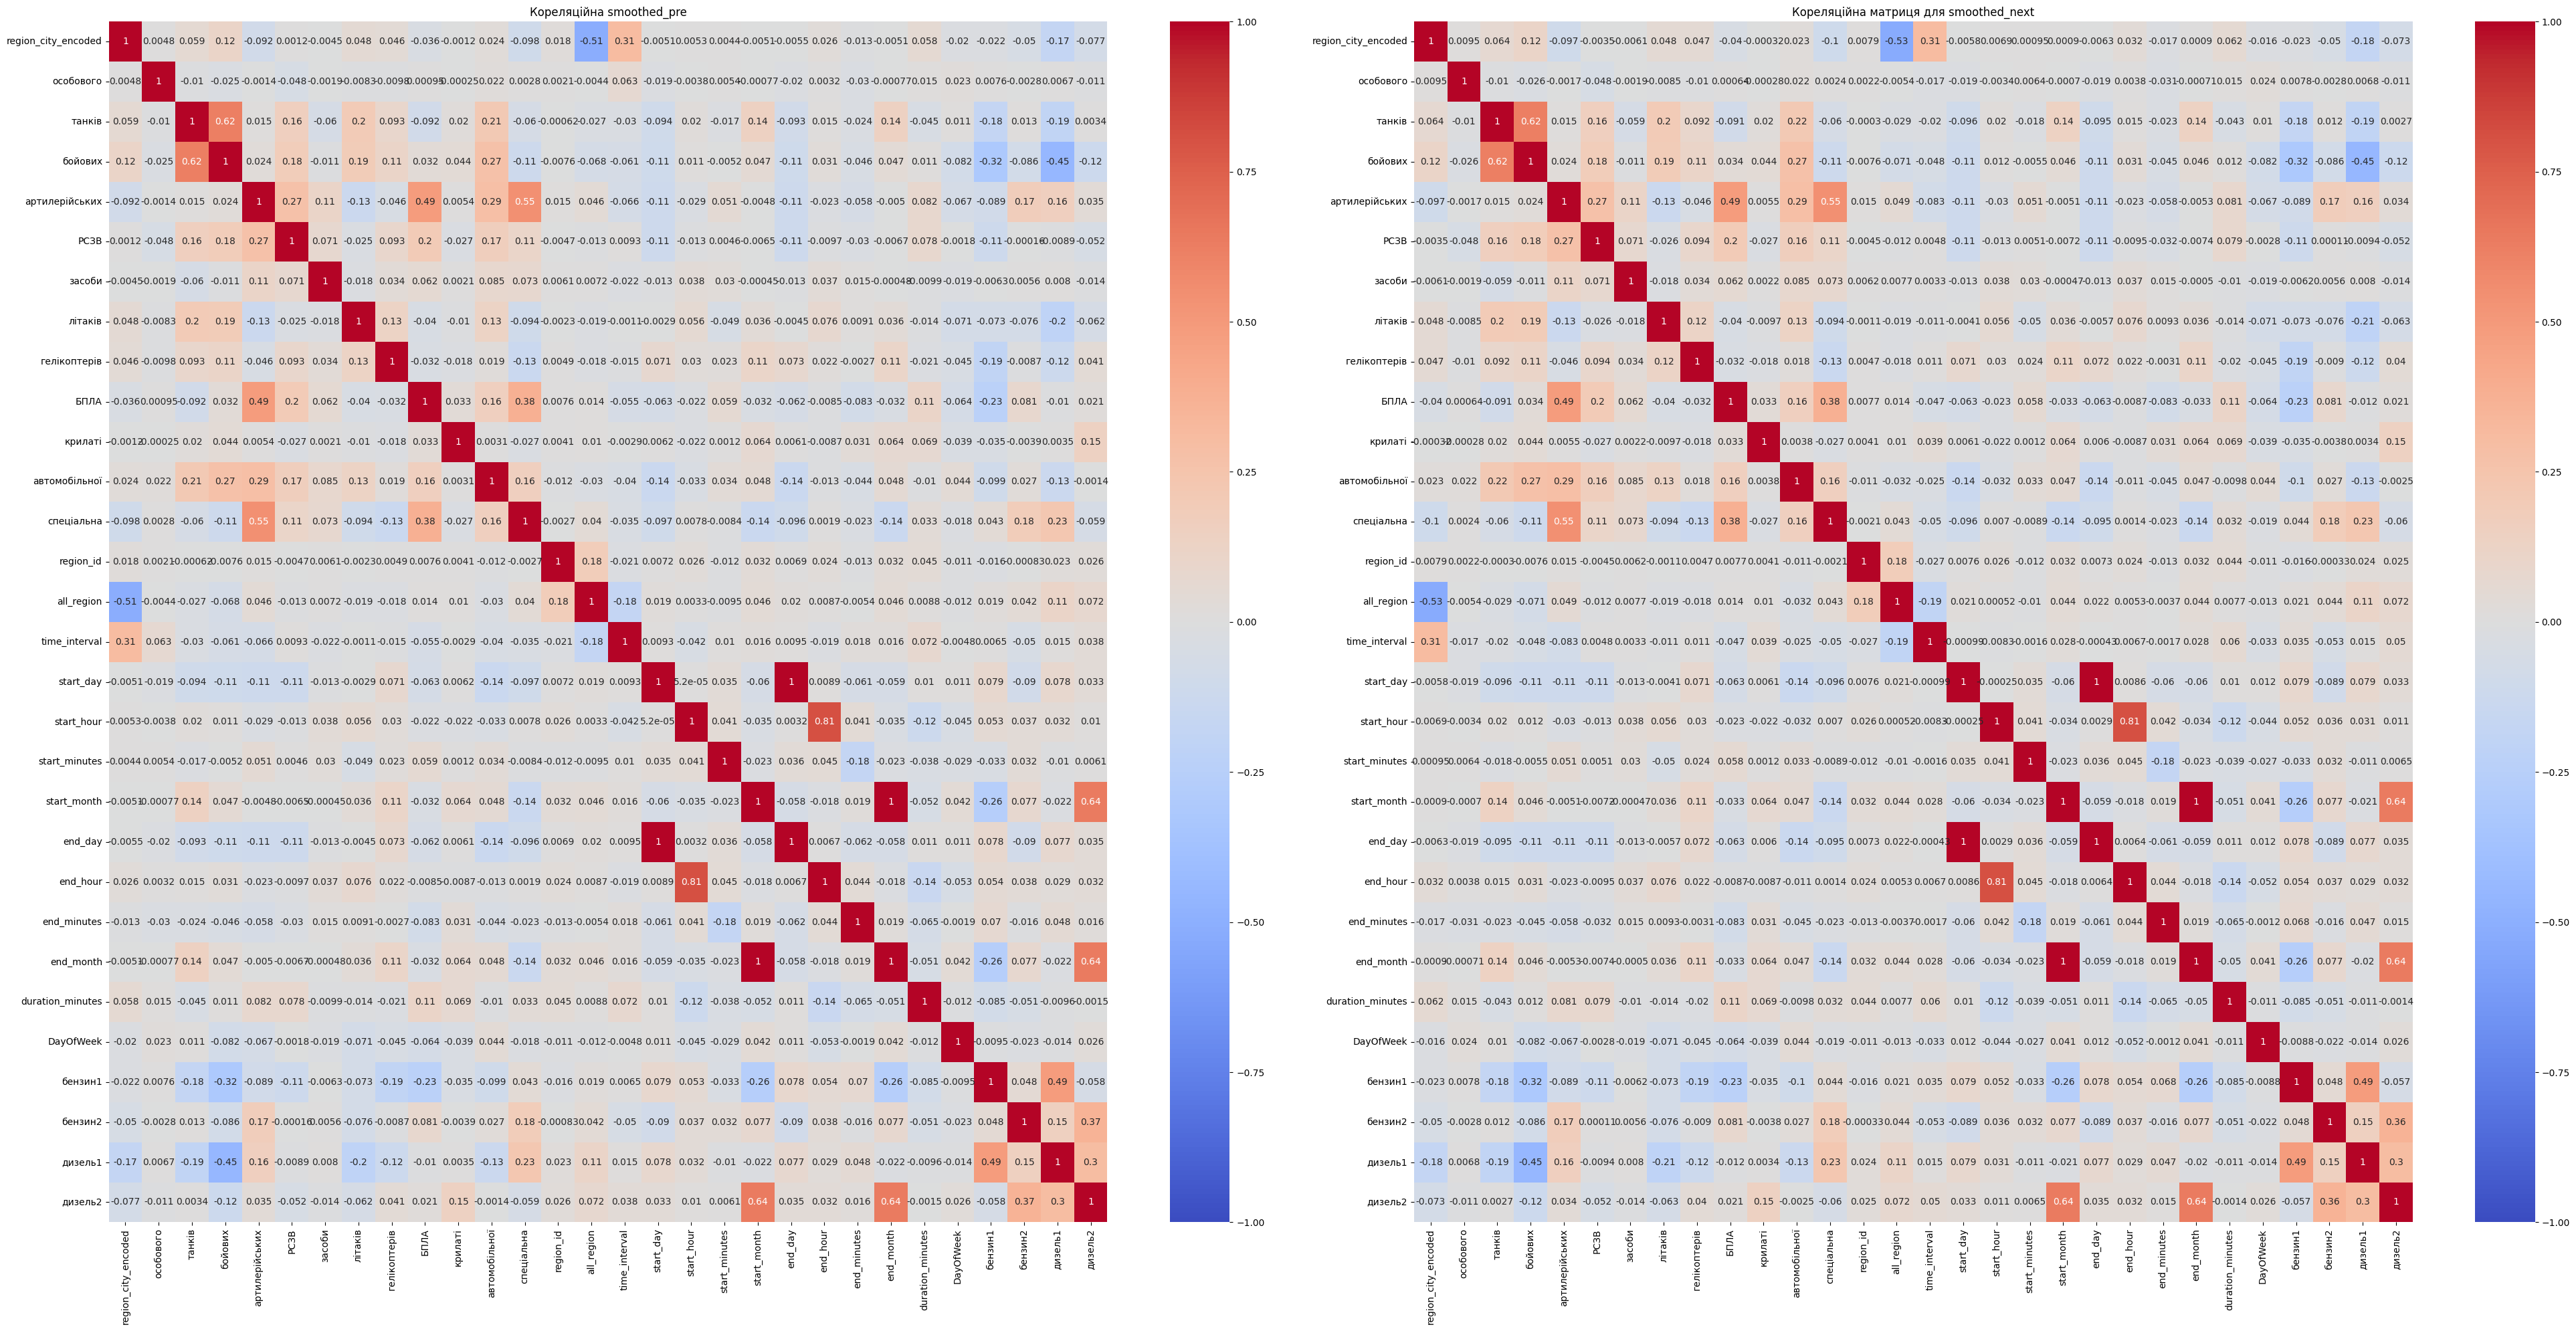

In [ ]:
corr1 = smoothed_pre.corr()
corr2 = smoothed_next.corr()


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(40, 20))

sns.heatmap(corr1, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Кореляційна smoothed_pre')

sns.heatmap(corr2, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Кореляційна матриця для smoothed_next')

plt.tight_layout()
plt.show()

In [ ]:

smoothed_next['region_id'] = pd.factorize(smoothed_next['region_id'])[0]

window_size_region=11
window_size_time=25
X2, y2 = data_split(smoothed_pre,'time_interval',window_size_time)
X2_train, y2_train = X2[:19000], y2[:19000]
X2_val, y2_val = X2[19000:19500], y2[19000:19500]
X2_test, y2_test = X2[19500:], y2[19500:]

X, y = data_split(smoothed_next,'region_id',window_size_region)
X_train, y_train = X[:19000], y[:19000]
X_val, y_val = X[19000:19500], y[19000:19500]
X_test, y_test = X[19500:], y[19500:]





In [ ]:
model_region = Sequential()
model_region.add(LSTM(50, input_shape=(window_size_region, X_train.shape[2]), return_sequences=True))
model_region.add(LSTM(32))
model_region.add(Dropout(0.3))
model_region.add(Dense(64, activation='relu'))
model_region.add(Dense(len(smoothed_next['region_id'].unique()), activation='softmax'))

model_region.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history_region = model_region.fit(X_train, y_train, epochs=75, validation_data=(X_val, y_val))

Epoch 1/75
594/594 [==============================] - 19s 25ms/step - loss: 2.8494 - accuracy: 0.1456 - val_loss: 2.8128 - val_accuracy: 0.2040
Epoch 2/75
594/594 [==============================] - 15s 25ms/step - loss: 2.7956 - accuracy: 0.1473 - val_loss: 2.7692 - val_accuracy: 0.2380
Epoch 3/75
594/594 [==============================] - 11s 18ms/step - loss: 2.7474 - accuracy: 0.1472 - val_loss: 2.7250 - val_accuracy: 0.1940
Epoch 4/75
594/594 [==============================] - 11s 18ms/step - loss: 2.7043 - accuracy: 0.1488 - val_loss: 2.6899 - val_accuracy: 0.1620
Epoch 5/75
594/594 [==============================] - 11s 18ms/step - loss: 2.6828 - accuracy: 0.1514 - val_loss: 2.6068 - val_accuracy: 0.2480
Epoch 6/75
594/594 [==============================] - 10s 17ms/step - loss: 2.6644 - accuracy: 0.1552 - val_loss: 2.6584 - val_accuracy: 0.2380
Epoch 7/75
594/594 [==============================] - 10s 17ms/step - loss: 2.6505 - accuracy: 0.1604 - val_loss: 2.5421 - val_accuracy:

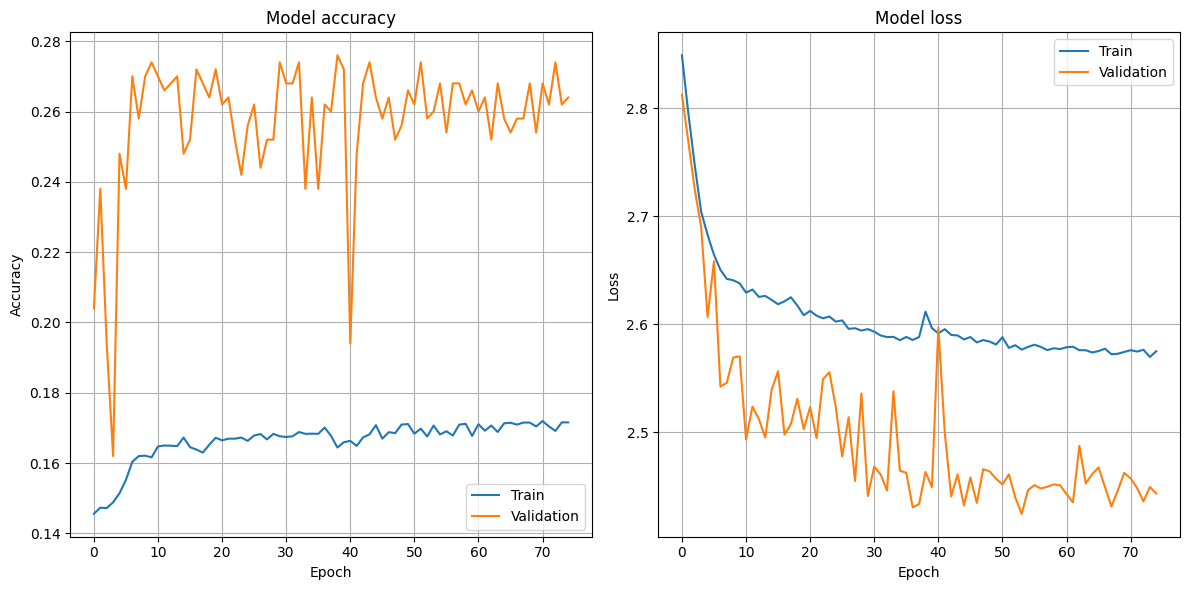

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_region.history['accuracy'], label='Train')
plt.plot(history_region.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_region.history['loss'], label='Train')
plt.plot(history_region.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model_time = Sequential()
model_time.add(Conv1D(64, kernel_size=2, activation='relu'))
model_time.add(Conv1D(32, kernel_size=2, activation='relu'))
model_time.add(Flatten())
model_time.add(Dense(64, activation='relu'))
model_time.add(Dense(32, activation='relu'))
model_time.add(Dense(16, activation='relu'))
model_time.add(Dense(1, activation='linear'))

cp_time = ModelCheckpoint('model_time/', save_best_only=True)
model_time.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Переконайтеся, що дані X2_train, y2_train, X2_test, y2_test підходять під вхідний розмір моделі.
history_time = model_time.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=75, callbacks=[cp_time])

Epoch 1/75
594/594 [==============================] - ETA: 0s - loss: 94848.6016 - root_mean_squared_error: 307.9750

594/594 [==============================] - 7s 9ms/step - loss: 94848.6016 - root_mean_squared_error: 307.9750 - val_loss: 662.7450 - val_root_mean_squared_error: 25.7438
Epoch 2/75
590/594 [============================>.] - ETA: 0s - loss: 18342.7109 - root_mean_squared_error: 135.4353

594/594 [==============================] - 6s 11ms/step - loss: 18232.4336 - root_mean_squared_error: 135.0275 - val_loss: 620.1740 - val_root_mean_squared_error: 24.9033
Epoch 3/75
588/594 [============================>.] - ETA: 0s - loss: 9939.9922 - root_mean_squared_error: 99.6995

594/594 [==============================] - 6s 10ms/step - loss: 9865.7354 - root_mean_squared_error: 99.3264 - val_loss: 588.6653 - val_root_mean_squared_error: 24.2624
Epoch 4/75
587/594 [============================>.] - ETA: 0s - loss: 5206.8384 - root_mean_squared_error: 72.1584

594/594 [==============================] - 6s 11ms/step - loss: 5153.9194 - root_mean_squared_error: 71.7908 - val_loss: 566.3542 - val_root_mean_squared_error: 23.7982
Epoch 5/75
587/594 [============================>.] - ETA: 0s - loss: 7065.2476 - root_mean_squared_error: 84.0550

594/594 [==============================] - 5s 9ms/step - loss: 7041.7251 - root_mean_squared_error: 83.9150 - val_loss: 530.1921 - val_root_mean_squared_error: 23.0259
Epoch 6/75
594/594 [==============================] - ETA: 0s - loss: 5270.9229 - root_mean_squared_error: 72.6011

594/594 [==============================] - 6s 11ms/step - loss: 5270.9229 - root_mean_squared_error: 72.6011 - val_loss: 427.7830 - val_root_mean_squared_error: 20.6829
Epoch 7/75
590/594 [============================>.] - ETA: 0s - loss: 8425.7617 - root_mean_squared_error: 91.7919

594/594 [==============================] - 6s 10ms/step - loss: 8398.8633 - root_mean_squared_error: 91.6453 - val_loss: 289.4980 - val_root_mean_squared_error: 17.0146
Epoch 8/75
592/594 [============================>.] - ETA: 0s - loss: 907.7567 - root_mean_squared_error: 30.1290

594/594 [==============================] - 6s 11ms/step - loss: 906.9653 - root_mean_squared_error: 30.1159 - val_loss: 237.5427 - val_root_mean_squared_error: 15.4124
Epoch 9/75
593/594 [============================>.] - ETA: 0s - loss: 860.9355 - root_mean_squared_error: 29.3417

594/594 [==============================] - 6s 11ms/step - loss: 860.0353 - root_mean_squared_error: 29.3264 - val_loss: 201.5500 - val_root_mean_squared_error: 14.1968
Epoch 10/75
592/594 [============================>.] - ETA: 0s - loss: 1703.5907 - root_mean_squared_error: 41.2746

594/594 [==============================] - 7s 11ms/step - loss: 1700.6753 - root_mean_squared_error: 41.2392 - val_loss: 180.4249 - val_root_mean_squared_error: 13.4322
Epoch 11/75
589/594 [============================>.] - ETA: 0s - loss: 1938.3593 - root_mean_squared_error: 44.0268

594/594 [==============================] - 6s 10ms/step - loss: 1924.1790 - root_mean_squared_error: 43.8655 - val_loss: 164.2247 - val_root_mean_squared_error: 12.8150
Epoch 12/75
592/594 [============================>.] - ETA: 0s - loss: 2666.3508 - root_mean_squared_error: 51.6367

594/594 [==============================] - 6s 11ms/step - loss: 2663.7056 - root_mean_squared_error: 51.6111 - val_loss: 151.1206 - val_root_mean_squared_error: 12.2931
Epoch 13/75
588/594 [============================>.] - ETA: 0s - loss: 1348.1049 - root_mean_squared_error: 36.7165

594/594 [==============================] - 6s 10ms/step - loss: 1354.3872 - root_mean_squared_error: 36.8020 - val_loss: 141.9580 - val_root_mean_squared_error: 11.9146
Epoch 14/75
593/594 [============================>.] - ETA: 0s - loss: 488.9763 - root_mean_squared_error: 22.1128

594/594 [==============================] - 6s 10ms/step - loss: 488.4007 - root_mean_squared_error: 22.0998 - val_loss: 122.3562 - val_root_mean_squared_error: 11.0615
Epoch 15/75
587/594 [============================>.] - ETA: 0s - loss: 689.2524 - root_mean_squared_error: 26.2536

594/594 [==============================] - 6s 10ms/step - loss: 688.1622 - root_mean_squared_error: 26.2328 - val_loss: 114.6349 - val_root_mean_squared_error: 10.7068
Epoch 16/75
594/594 [==============================] - 4s 7ms/step - loss: 526.9314 - root_mean_squared_error: 22.9550 - val_loss: 152.6975 - val_root_mean_squared_error: 12.3571
Epoch 17/75
589/594 [============================>.] - ETA: 0s - loss: 448.8976 - root_mean_squared_error: 21.1872

594/594 [==============================] - 7s 12ms/step - loss: 458.8782 - root_mean_squared_error: 21.4214 - val_loss: 110.9525 - val_root_mean_squared_error: 10.5334
Epoch 18/75
588/594 [============================>.] - ETA: 0s - loss: 1152.8977 - root_mean_squared_error: 33.9543

594/594 [==============================] - 7s 11ms/step - loss: 1143.4369 - root_mean_squared_error: 33.8147 - val_loss: 100.0818 - val_root_mean_squared_error: 10.0041
Epoch 19/75
594/594 [==============================] - 5s 9ms/step - loss: 452.6007 - root_mean_squared_error: 21.2744 - val_loss: 101.6888 - val_root_mean_squared_error: 10.0841
Epoch 20/75
594/594 [==============================] - 4s 7ms/step - loss: 243.9927 - root_mean_squared_error: 15.6203 - val_loss: 101.5735 - val_root_mean_squared_error: 10.0784
Epoch 21/75
594/594 [==============================] - 4s 7ms/step - loss: 325.5576 - root_mean_squared_error: 18.0432 - val_loss: 127.0893 - val_root_mean_squared_error: 11.2734
Epoch 22/75
594/594 [==============================] - 5s 9ms/step - loss: 496.2903 - root_mean_squared_error: 22.2776 - val_loss: 102.8947 - val_root_mean_squared_error: 10.1437
Epoch 23/75
594/594 [==============================] - 4s 7ms/step - loss: 302.4151 - root_mean_squared_error: 17.3

594/594 [==============================] - 6s 11ms/step - loss: 197.5645 - root_mean_squared_error: 14.0558 - val_loss: 93.0608 - val_root_mean_squared_error: 9.6468
Epoch 26/75
594/594 [==============================] - 4s 7ms/step - loss: 171.6067 - root_mean_squared_error: 13.0999 - val_loss: 116.6609 - val_root_mean_squared_error: 10.8010
Epoch 27/75
594/594 [==============================] - 5s 9ms/step - loss: 162.2318 - root_mean_squared_error: 12.7370 - val_loss: 96.4707 - val_root_mean_squared_error: 9.8219
Epoch 28/75
594/594 [==============================] - 5s 8ms/step - loss: 162.9080 - root_mean_squared_error: 12.7635 - val_loss: 108.0437 - val_root_mean_squared_error: 10.3944
Epoch 29/75
594/594 [==============================] - 4s 7ms/step - loss: 164.2088 - root_mean_squared_error: 12.8144 - val_loss: 102.8703 - val_root_mean_squared_error: 10.1425
Epoch 30/75
594/594 [==============================] - 5s 9ms/step - loss: 172.5147 - root_mean_squared_error: 13.1345 -

594/594 [==============================] - 7s 11ms/step - loss: 190.1519 - root_mean_squared_error: 13.7896 - val_loss: 91.2578 - val_root_mean_squared_error: 9.5529
Epoch 33/75
594/594 [==============================] - 4s 7ms/step - loss: 160.6267 - root_mean_squared_error: 12.6739 - val_loss: 103.8371 - val_root_mean_squared_error: 10.1900
Epoch 34/75
594/594 [==============================] - 4s 7ms/step - loss: 159.4627 - root_mean_squared_error: 12.6279 - val_loss: 96.3686 - val_root_mean_squared_error: 9.8168
Epoch 35/75
594/594 [==============================] - 5s 9ms/step - loss: 163.7723 - root_mean_squared_error: 12.7974 - val_loss: 91.4015 - val_root_mean_squared_error: 9.5604
Epoch 36/75
594/594 [==============================] - 4s 7ms/step - loss: 158.7466 - root_mean_squared_error: 12.5995 - val_loss: 146.7393 - val_root_mean_squared_error: 12.1136
Epoch 37/75
594/594 [==============================] - 4s 7ms/step - loss: 146.8596 - root_mean_squared_error: 12.1186 - v

594/594 [==============================] - 5s 9ms/step - loss: 349.9131 - root_mean_squared_error: 18.7060 - val_loss: 88.9020 - val_root_mean_squared_error: 9.4288
Epoch 46/75
594/594 [==============================] - 5s 9ms/step - loss: 141.2611 - root_mean_squared_error: 11.8853 - val_loss: 98.0064 - val_root_mean_squared_error: 9.8998
Epoch 47/75
594/594 [==============================] - 4s 7ms/step - loss: 143.2641 - root_mean_squared_error: 11.9693 - val_loss: 111.5317 - val_root_mean_squared_error: 10.5609
Epoch 48/75
594/594 [==============================] - 4s 7ms/step - loss: 134.1039 - root_mean_squared_error: 11.5803 - val_loss: 93.9168 - val_root_mean_squared_error: 9.6911
Epoch 49/75
594/594 [==============================] - 5s 9ms/step - loss: 132.1248 - root_mean_squared_error: 11.4946 - val_loss: 105.5575 - val_root_mean_squared_error: 10.2741
Epoch 50/75
594/594 [==============================] - 4s 7ms/step - loss: 132.7025 - root_mean_squared_error: 11.5197 - va

594/594 [==============================] - 6s 10ms/step - loss: 125.0486 - root_mean_squared_error: 11.1825 - val_loss: 83.1440 - val_root_mean_squared_error: 9.1183
Epoch 67/75
594/594 [==============================] - 4s 7ms/step - loss: 123.6934 - root_mean_squared_error: 11.1218 - val_loss: 88.0375 - val_root_mean_squared_error: 9.3828
Epoch 68/75
594/594 [==============================] - 4s 7ms/step - loss: 123.5643 - root_mean_squared_error: 11.1159 - val_loss: 93.9812 - val_root_mean_squared_error: 9.6944
Epoch 69/75
594/594 [==============================] - 5s 8ms/step - loss: 123.1513 - root_mean_squared_error: 11.0974 - val_loss: 103.2534 - val_root_mean_squared_error: 10.1614
Epoch 70/75
594/594 [==============================] - 4s 7ms/step - loss: 123.3438 - root_mean_squared_error: 11.1060 - val_loss: 85.7457 - val_root_mean_squared_error: 9.2599
Epoch 71/75
589/594 [============================>.] - ETA: 0s - loss: 124.0428 - root_mean_squared_error: 11.1375

594/594 [==============================] - 5s 9ms/step - loss: 123.3181 - root_mean_squared_error: 11.1049 - val_loss: 81.1903 - val_root_mean_squared_error: 9.0106
Epoch 72/75
594/594 [==============================] - 5s 8ms/step - loss: 137.0320 - root_mean_squared_error: 11.7061 - val_loss: 100.8442 - val_root_mean_squared_error: 10.0421
Epoch 73/75
594/594 [==============================] - 4s 7ms/step - loss: 123.1527 - root_mean_squared_error: 11.0974 - val_loss: 84.0869 - val_root_mean_squared_error: 9.1699
Epoch 74/75
594/594 [==============================] - 4s 7ms/step - loss: 123.9939 - root_mean_squared_error: 11.1353 - val_loss: 89.9721 - val_root_mean_squared_error: 9.4854
Epoch 75/75
594/594 [==============================] - 5s 8ms/step - loss: 121.2777 - root_mean_squared_error: 11.0126 - val_loss: 82.8562 - val_root_mean_squared_error: 9.1025


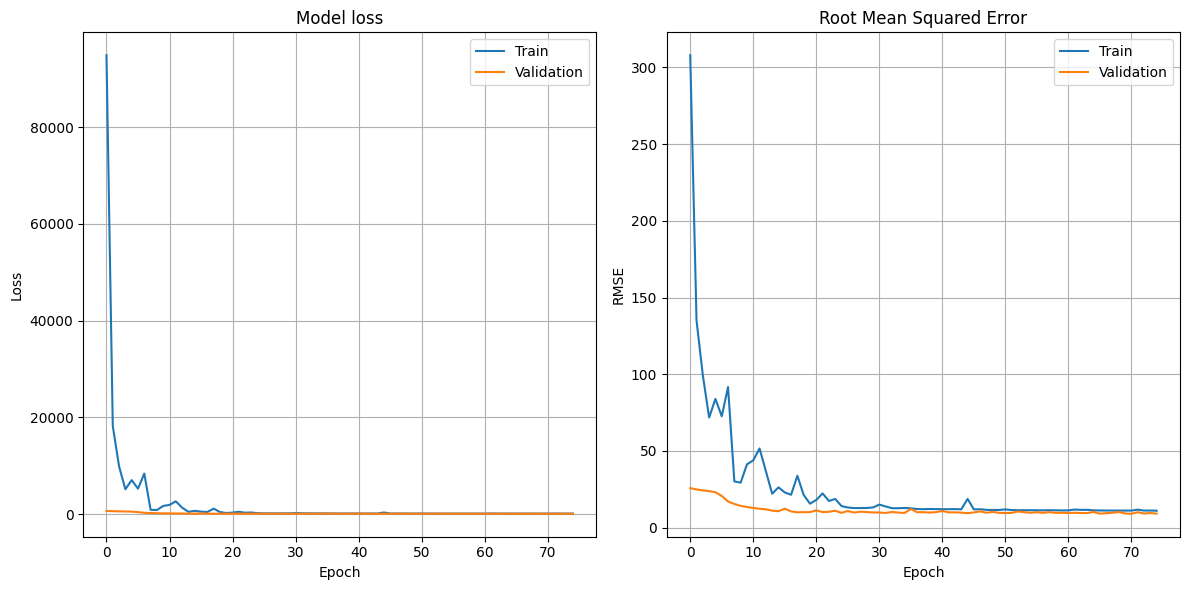

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_time.history['loss'], label='Train')
plt.plot(history_time.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation RMSE values
plt.subplot(1, 2, 2)
plt.plot(history_time.history['root_mean_squared_error'], label='Train')
plt.plot(history_time.history['val_root_mean_squared_error'], label='Validation')
plt.title('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
plot_predictions1(model_time, X2_val, y2_val,0,1000)
